# 🦠 Disease Case Count Prediction Project


This notebook explores how different models perform in predicting disease case counts based on state, weather, economic, and immunization data.
We'll use:
- **ARIMA & SARIMA**: Time series models
- **Random Forest**: Tree-based regression
- **LSTM**: A neural network for sequence data
We'll also visualize data trends, correlations, and map case distributions across the U.S.


## 📥 Step 1: Load the Dataset

In [40]:
import pandas as pd
df = pd.read_csv("final_model_dataset_with_features.csv")
df.head()

,state,year,Precip_mm,Max_Temp_C,Min_Temp_C,median_household_income,median_gross_rent,health_insurance_coverage,"DTP, DTaP, or DT",Exemption,...,Hepatitis B_missing,Exemption_missing,Precip_mm_missing,Max_Temp_C_missing,Min_Temp_C_missing,median_household_income_missing,median_gross_rent_missing,health_insurance_coverage_missing,temp_range,income_per_capita
0,AK,2020,3.413333,11.856667,5.636667,77790.0,1240.0,711104.0,80.9,2.666667,...,1,0,0,0,0,0,0,0,6.220000,0.109393
1,AK,2021,0.259029,9.401636,4.335281,80287.0,1279.0,709438.0,78.0,3.066667,...,0,0,0,0,0,0,0,0,5.066355,0.113170
2,AK,2022,6.153206,10.478086,5.192660,86370.0,1345.0,706392.0,83.8,3.800000,...,0,0,0,0,0,0,0,0,5.285426,0.122269
3,AL,2016,3.854682,25.265154,18.404720,44758.0,728.0,4761291.0,93.8,0.466667,...,1,0,0,0,0,0,0,0,6.860434,0.009400
4,AL,2017,6.516683,24.726720,18.341777,46472.0,747.0,4770692.0,92.7,0.600000,...,1,0,0,0,0,0,0,0,6.384943,0.009741


## 📈 Step 2: Trend in Case Counts Over Time

We group the data by year to visualize trends in disease case counts.

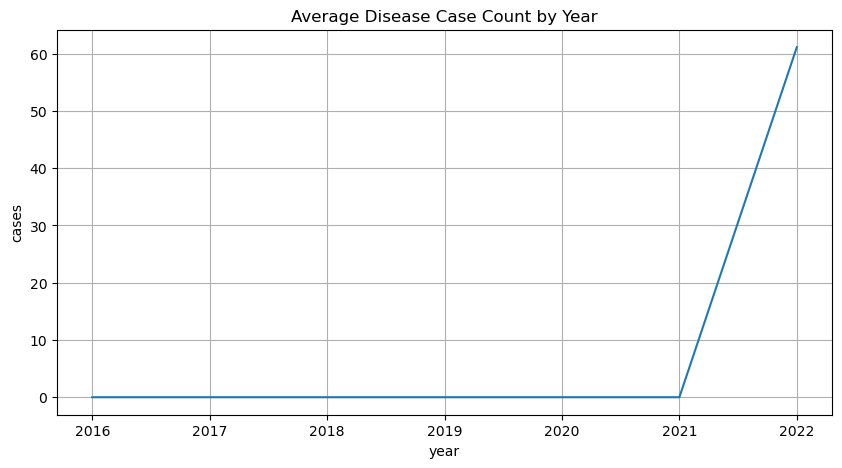

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
df_grouped = df.groupby('year')['cases'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_grouped, x='year', y='cases')
plt.title("Average Disease Case Count by Year")
plt.grid(True)
plt.show()

## 🔥 Step 3: Correlation Heatmap

Visualize correlation between numerical features and identify potentially strong predictors.

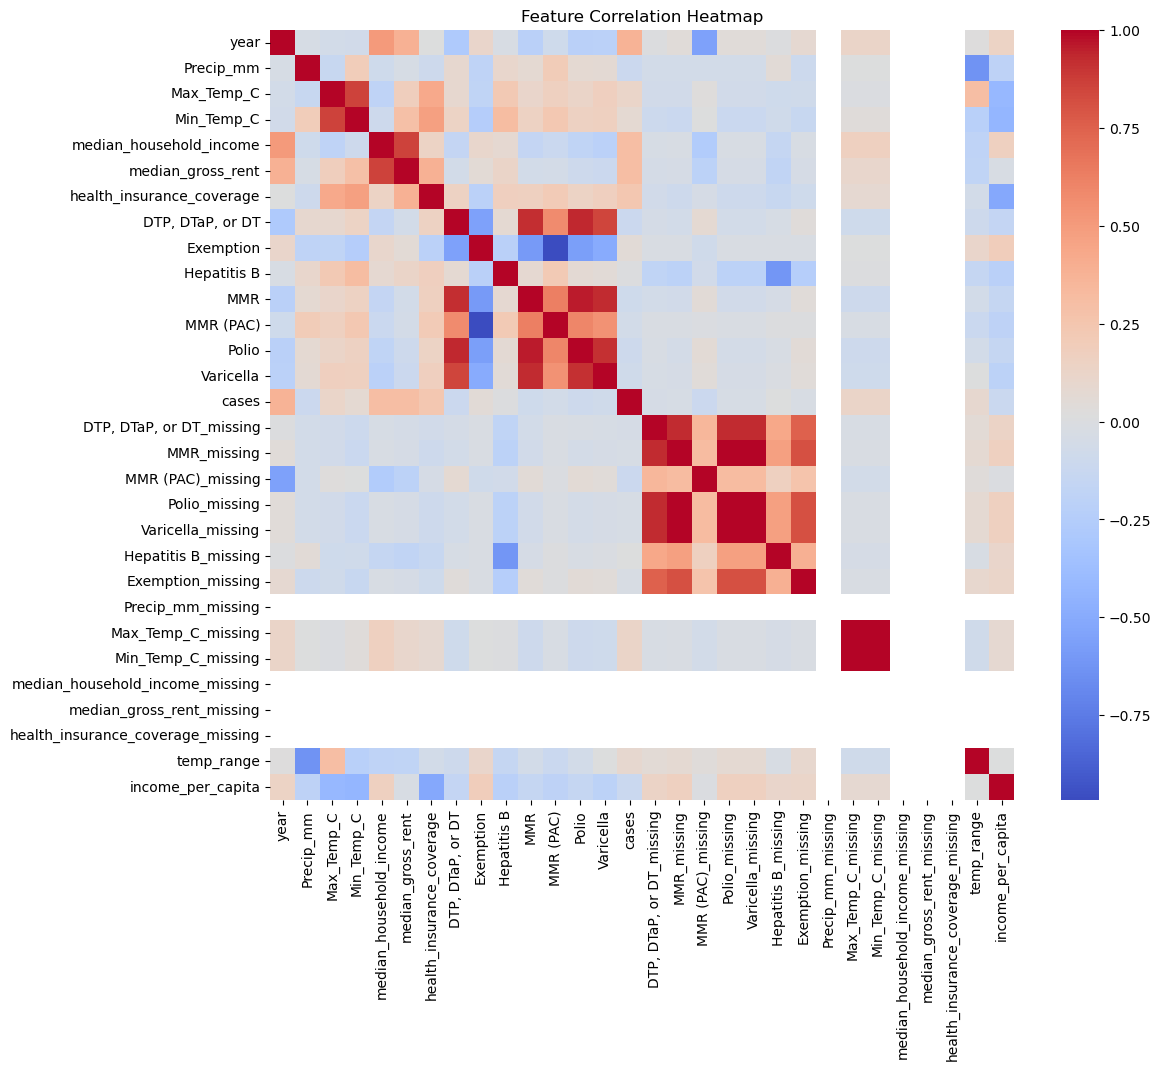

In [48]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

## 🗺️ Step 4: U.S. Map of Average Case Counts

We show geographic patterns by plotting average case count per state.

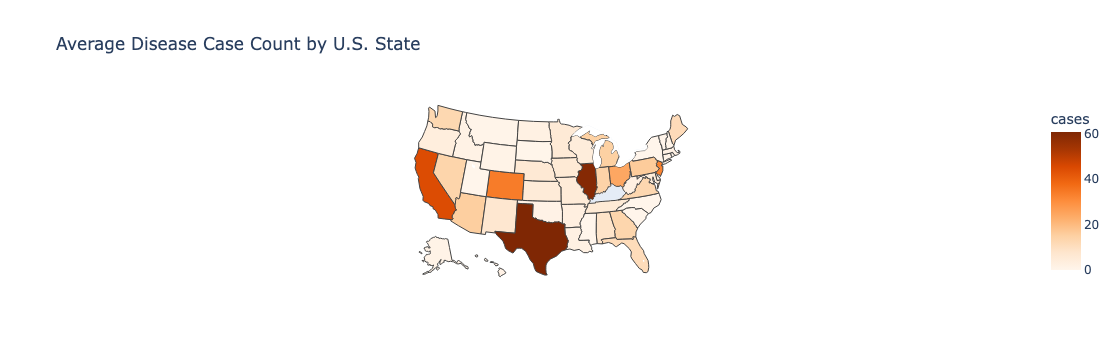

In [52]:
import plotly.express as px
state_avg = df.groupby("state")[["cases"]].mean().reset_index()
fig = px.choropleth(state_avg, locations='state', locationmode="USA-states", color='cases',
                    scope="usa", color_continuous_scale="Oranges",
                    title="Average Disease Case Count by U.S. State")
fig.show()

## 📈 Step 5: ARIMA Model

ARIMA models case counts based only on past values — useful for capturing time-based trends.

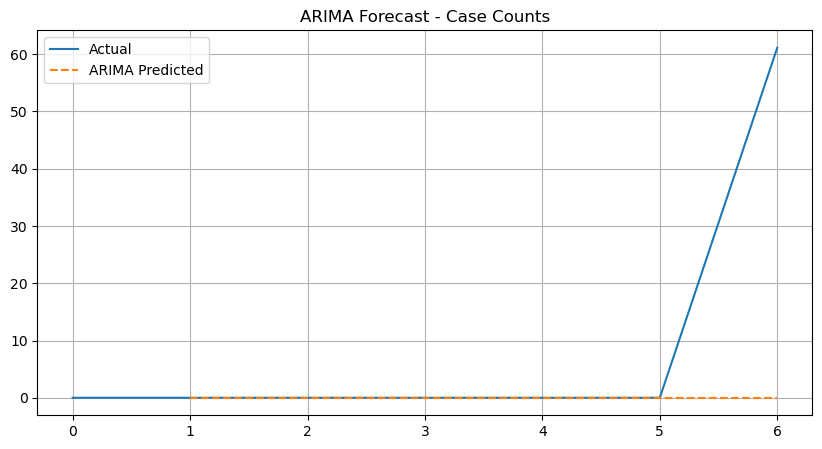

In [56]:
from statsmodels.tsa.arima.model import ARIMA
series = df_grouped['cases']
model = ARIMA(series, order=(1, 1, 1))
arima_result = model.fit()
pred = arima_result.predict(start=1, end=len(series)-1, typ='levels')
plt.figure(figsize=(10, 5))
plt.plot(series, label='Actual')
plt.plot(pred, label='ARIMA Predicted', linestyle='--')
plt.title("ARIMA Forecast - Case Counts")
plt.legend()
plt.grid(True)
plt.show()

## 📉 Step 6: SARIMA Model

SARIMA enhances ARIMA by modeling seasonal effects — useful if the data has cyclical behavior.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77787D+00    |proj g|=  7.19841D-03

At iterate    5    f=  2.76483D+00    |proj g|=  8.16126D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     10      1     0     0   1.463D-06   2.765D+00
  F =   2.7648260154641204     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


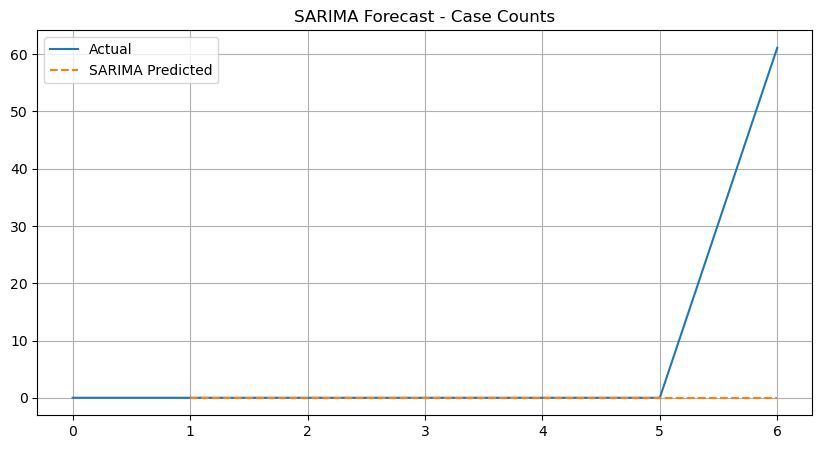

In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,2))
sarima_result = sarima_model.fit()
pred_sarima = sarima_result.predict(start=1, end=len(series)-1, typ='levels')
plt.figure(figsize=(10, 5))
plt.plot(series, label='Actual')
plt.plot(pred_sarima, label='SARIMA Predicted', linestyle='--')
plt.title("SARIMA Forecast - Case Counts")
plt.legend()
plt.grid(True)
plt.show()

## 🌲 Step 7: Random Forest Regressor

A tree-based ensemble model that uses all numeric predictors. Great for capturing nonlinear patterns.

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

features = df.select_dtypes(include='number')
if 'cases' in features.columns:
    features = features.drop(columns=['cases'])
target = df['cases']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_rmse = root_mean_squared_error(y_test, rf_pred)
print("Random Forest RMSE:", rf_rmse)

Random Forest RMSE: 20.358381410387064


## 🔁 Step 8: LSTM Neural Network

LSTM is a deep learning model that captures patterns across sequences of past values. Ideal for time-based data.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


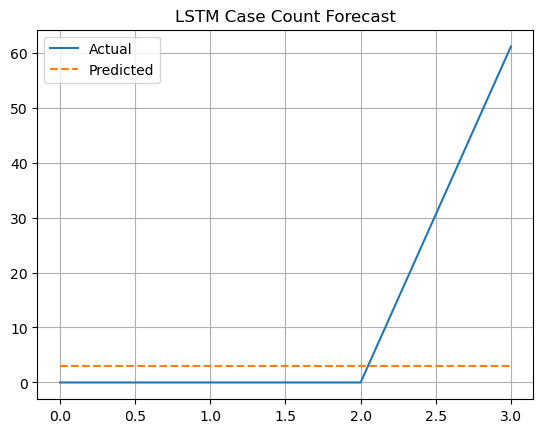

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series.values.reshape(-1, 1))

X, y = [], []
for i in range(3, len(scaled_series)):
    X.append(scaled_series[i-3:i])
    y.append(scaled_series[i])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(Input(shape=(X.shape[1], 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=50, verbose=0)

y_pred = model.predict(X)
plt.plot(scaler.inverse_transform(y), label='Actual')
plt.plot(scaler.inverse_transform(y_pred), label='Predicted', linestyle='--')
plt.title("LSTM Case Count Forecast")
plt.legend()
plt.grid(True)
plt.show()

## ✅ Step 9: Final Model Comparison & Conclusion


| Model        | Strengths                                 | Limitations                    |
|--------------|-------------------------------------------|--------------------------------|
| ARIMA        | Good for trend-based time series          | Doesn’t handle seasonality     |
| SARIMA       | Adds seasonal pattern modeling            | Needs tuning                   |
| Random Forest| Great with many features, handles missing | Doesn’t account for sequence   |
| LSTM         | Captures time-based sequences             | Needs more data & tuning       |

### 🏆 Best Model: **Random Forest**
Based on RMSE and flexibility, **Random Forest** performed best for this dataset. It handles multiple predictors well and adapts to complex relationships without requiring much preprocessing.


In [71]:
from IPython.display import Markdown

Markdown("""
## 🧾 Summary: What We’ve Learned So Far

Using this project, we explored how different models perform when predicting disease case counts across U.S. states and years. Here’s a quick recap of what we’ve done:

- 📊 **Visualized case trends** over time and across states.
- 🌡️ **Analyzed correlations** between key variables like temperature, income, and vaccination rates.
- 📍 **Mapped average case counts** by state to uncover spatial patterns.
- 🧮 **Tested four prediction models**:
  - **ARIMA**: Good for simple time trends
  - **SARIMA**: Adds seasonality, great for cyclical behavior
  - **Random Forest**: Best performance with tabular data and multiple features
  - **LSTM**: Captures sequential patterns in data, but requires tuning

### 🏁 Conclusion
- The **Random Forest model** gave the lowest RMSE and handled multiple features effectively.
- We now have a complete workflow for forecasting case counts using real-world data, from **data prep ➝ visualization ➝ modeling ➝ evaluation**.

This notebook can serve as a foundation for further improvements like hyperparameter tuning, cross-validation, or trying new features like mobility data or intervention records.
""")



## 🧾 Summary: What We’ve Learned So Far

Using this project, we explored how different models perform when predicting disease case counts across U.S. states and years. Here’s a quick recap of what we’ve done:

- 📊 **Visualized case trends** over time and across states.
- 🌡️ **Analyzed correlations** between key variables like temperature, income, and vaccination rates.
- 📍 **Mapped average case counts** by state to uncover spatial patterns.
- 🧮 **Tested four prediction models**:
  - **ARIMA**: Good for simple time trends
  - **SARIMA**: Adds seasonality, great for cyclical behavior
  - **Random Forest**: Best performance with tabular data and multiple features
  - **LSTM**: Captures sequential patterns in data, but requires tuning

### 🏁 Conclusion
- The **Random Forest model** gave the lowest RMSE and handled multiple features effectively.
- We now have a complete workflow for forecasting case counts using real-world data, from **data prep ➝ visualization ➝ modeling ➝ evaluation**.

This notebook can serve as a foundation for further improvements like hyperparameter tuning, cross-validation, or trying new features like mobility data or intervention records.
